In [1]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import docx

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samue\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\samue\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Se hicieron tres consultas en el crea con los siguientes temas:

- Deportes
- Viajes
- Ciencia

In [2]:
# Abre los documentos de Word
doc_ciencia = docx.Document("ExportacionWordCREA_Ciencia.doc")
doc_deporte = docx.Document("ExportacionWordCREA_Deporte.doc")
doc_viaje = docx.Document("ExportacionWordCREA_Viaje.doc")

archivos = [doc_ciencia, doc_deporte, doc_viaje]

# Inicializa listas para los títulos y textos
titulos = []
documentos = []

# Inicializa una bandera para determinar si estamos en una sección de título o texto
en_titulo = True

# Recorre el contenido del documento
for doc in archivos:
    for paragraph in doc.paragraphs[2:]:
        if paragraph.text:  # Verifica si el párrafo no está vacío
            if en_titulo:
                titulos.append(paragraph.text)
            else:
                documentos.append(paragraph.text)
            # Cambia la bandera en_titulo en cada iteración
            en_titulo = not en_titulo

print(f"Numero de documentos: {len(documentos)}")

Numero de documentos: 491


In [3]:
# Definir las funciones de preprocesamiento
def preprocess_text(text):
    # Tokenización personalizada para mantener solo palabras (sin números ni signos de puntuación)
    tokenizer = RegexpTokenizer(r'\b[^\d\W]+\b')
    words = tokenizer.tokenize(text)
    
    # Eliminación de stopwords
    stop_words = set(stopwords.words('spanish')) 
    words = [word for word in words if word.lower() not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    # Lematización
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(words)

tfidf_vectorizer = TfidfVectorizer(preprocessor=preprocess_text, min_df=0.01) #Eliminamos las palabras que aparezcan en menos del 1% de los documentos
tfidf_matrix = tfidf_vectorizer.fit_transform(documentos)
words = tfidf_vectorizer.get_feature_names_out()


term_frequency_df = pd.DataFrame(tfidf_matrix.toarray(), columns=words)
print(term_frequency_df)



     abierto  accident    accion  acción  actitud  actividad   actual   
0        0.0       0.0  0.192409     0.0      0.0        0.0  0.00000  \
1        0.0       0.0  0.000000     0.0      0.0        0.0  0.00000   
2        0.0       0.0  0.000000     0.0      0.0        0.0  0.00000   
3        0.0       0.0  0.000000     0.0      0.0        0.0  0.00000   
4        0.0       0.0  0.000000     0.0      0.0        0.0  0.15876   
..       ...       ...       ...     ...      ...        ...      ...   
486      0.0       0.0  0.000000     0.0      0.0        0.0  0.00000   
487      0.0       0.0  0.000000     0.0      0.0        0.0  0.00000   
488      0.0       0.0  0.000000     0.0      0.0        0.0  0.00000   
489      0.0       0.0  0.000000     0.0      0.0        0.0  0.00000   
490      0.0       0.0  0.000000     0.0      0.0        0.0  0.00000   

     acuerdo  adecuada  adelant  ...  época  ésta  étnico  éxito  íbamo   
0        0.0  0.000000      0.0  ...    0.0   0.

Se usó TF-IDF para normalizar la importancia de términos comunes en los documentos y amplificar la importancia de los términos menos comunes. 

c:\Users\samue\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\samue\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


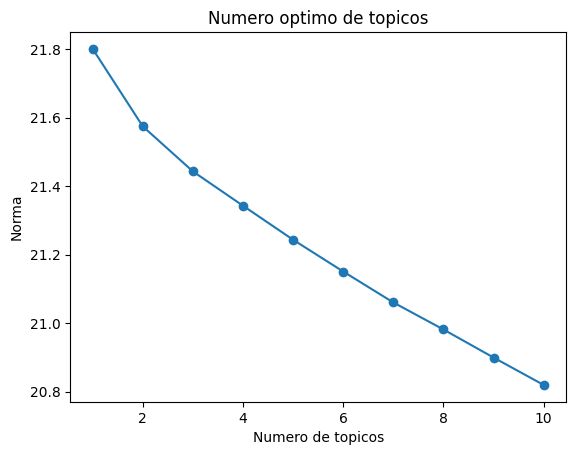

In [4]:
num_topics_range = range(1, 11)
norms = []

for num_topics in num_topics_range:
    nmf_model = NMF(n_components=num_topics, random_state=1)
    W = nmf_model.fit_transform(tfidf_matrix)
    H = nmf_model.components_
    approx = np.dot(W, H)
    norm = np.linalg.norm(tfidf_matrix - approx)
    norms.append(norm)


plt.plot(num_topics_range, norms, marker='o')
plt.xlabel('Numero de topicos')
plt.ylabel('Norma')
plt.title('Numero optimo de topicos')
plt.show()

En este caso debido a varios factores como el tamaño de la matriz de documentos, la calidad de las consultas y errores en la tokenizacion de palabras, no se puede determinar el número óptimo de tópicos. 

Sin embargo, se puede ver en la gráfica como a medida que aumenta el número de tópicos disminuye el error. 

In [5]:
num_topics = 5
model = NMF(n_components=num_topics)

W = model.fit_transform(tfidf_matrix)
H = model.components_

for topic_idx, topic in enumerate(H):
    
    print(f"\nTopico {topic_idx + 1}:")
    top_terms = [words[i] for i in topic.argsort()[:-11:-1]]
    print(", ".join(top_terms))


Topico 1:
medicina, social, ciencia, médica, estructura, liber, médico, sistema, cambio, europa

Topico 2:
si, viajar, día, despué, jugar, partido, hacer, air, mundo, bueno

Topico 3:
deport, dijo, tigr, nunca, mendoza, oficina, periódico, va, bien, jefe

Topico 4:
salud, ciencia, investigación, social, problema, aspecto, científico, desarrollo, mayor, pública

Topico 5:
ciencia, historia, hombr, antropología, cultura, conocimiento, natural, social, alimento, vida


Se calcularon cinco tópicos, cada uno con 10 palabras, donde se pueden ver los tres temas de las consultas. 